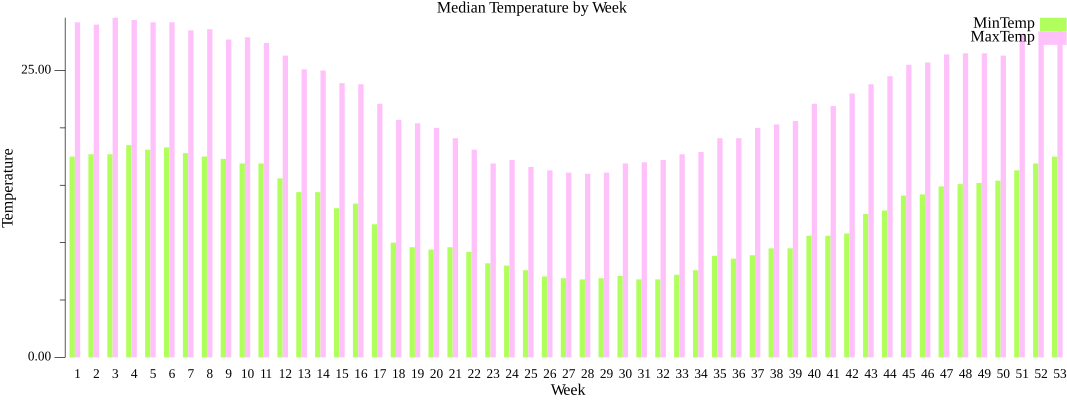

In [11]:
%%

Show2ColBarPlotPeriod(data, "Week", "MinTemp", "MaxTemp", "Temperature", 4)

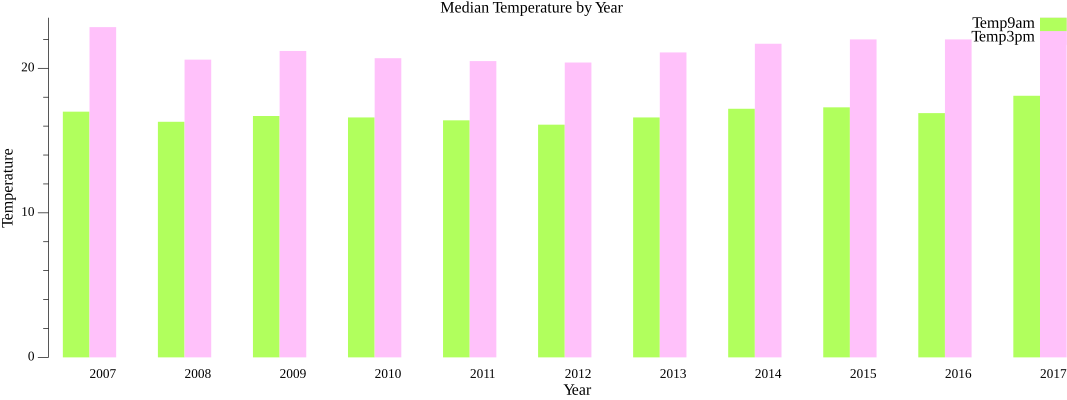

In [12]:
%%

Show2ColBarPlotPeriod(data, "Year", "Temp9am", "Temp3pm", "Temperature", 20)

In [15]:
func ShowHistogram (df dataframe.DataFrame, col string) {
    
    s := df.Col(col)
    meanValue := GetMeanValue(s)
    medianValue := s.Median()
    q1 := GetQuantileValue(s, 0.48)
    q2 := GetQuantileValue(s, 0.52)
    lenght := float64(df.
                      Filter(dataframe.F{Colname: col, Comparator: series.Greater, Comparando: q1}).
                      Filter(dataframe.F{Colname: col, Comparator: series.Less, Comparando: q2}).
                      Nrow())

    values := make(plotter.Values, s.Len())
    values1 := make(plotter.Values, 4000)
    switch s.Type() {
        case "float":
            for i := range values {
                if !s.Elem(i).IsNA() {
                    elem := s.Elem(i).Float()
                    values[i] = elem
                }
            }
        case "int":
            for i := range values {
                if !s.Elem(i).IsNA() {
                    elem, _ := s.Elem(i).Int()
                    values[i] = float64(elem)
                }
            }
        }
    for i := range values1 {
        values1[i] = float64(25.)
        }
   
	p := plot.New()
	p.Title.Text = fmt.Sprintf("Distribution of values ​​for %s", col)
    p.Y.Label.Text = fmt.Sprintf("count")
    p.X.Label.Text = fmt.Sprintf("values")

	h, err := plotter.NewHist(values, 100)
	if err != nil {
		panic(err)
	} 
    h.FillColor = color.RGBA{177, 255, 93, 255}

    mean, err := plotter.NewLine(plotter.XYs{{meanValue, 0}, {meanValue, lenght}})
	if err != nil {
		panic(err)
	}
    mean.Dashes = []vg.Length{vg.Points(2), vg.Points(2)}
	mean.Color = color.RGBA{255, 0, 14, 255}

    median, err := plotter.NewLine(plotter.XYs{{medianValue, 0}, {medianValue, lenght}})
	if err != nil {
		panic(err)
	}
    median.Dashes = []vg.Length{vg.Points(2), vg.Points(2)}
	median.Color = color.RGBA{76, 0, 15, 255}
    
    p.Add(h, mean, median)

    p.Legend.Add("values", h)
    p.Legend.Add("mean value", mean)
    p.Legend.Add("median value", median)
    p.Legend.Top = true

	buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(500)), vg.Points(float64(300)), "png")
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    gonbui.DisplayPNG(buf.Bytes())
}

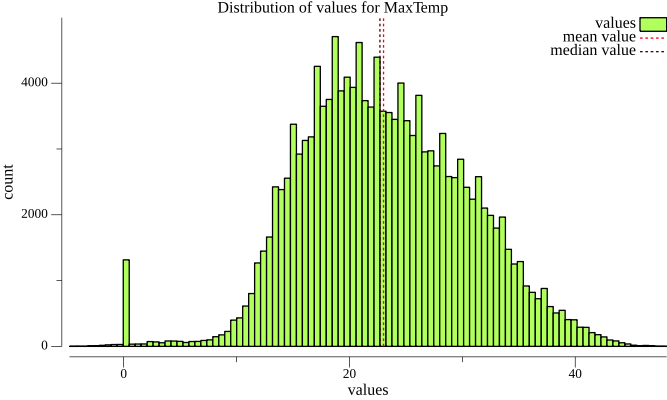

In [16]:
%%
ShowHistogram(data, "MaxTemp")

In [17]:
func Show2ColsBoxPlot (s1, s2 series.Series, t1, t2, significative string) {
    
    values1 := make(plotter.Values, s1.Len())
    values2 := make(plotter.Values, s2.Len())
    
    switch s1.Type() {
        case "float":
            for i := range values1 {
                if !s1.Elem(i).IsNA() && !s2.Elem(i).IsNA() {
                    elem := s1.Elem(i).Float()
                    values1[i] = elem
                    elem = s2.Elem(i).Float()
                    values2[i] = elem
                }
            }
        case "int":
            for i := range values1 {
                if !s1.Elem(i).IsNA() && !s2.Elem(i).IsNA() {
                    elem, _ := s1.Elem(i).Int()
                    values1[i] = float64(elem)
                    elem, _ = s2.Elem(i).Int()
                    values2[i] = float64(elem)
                }
            }
        }
    
    p := plot.New()
	p.Title.Text = fmt.Sprintf("Box plots ​​for %s", significative)
    p.Y.Label.Text = fmt.Sprintf("values")
    p.X.Label.Text = fmt.Sprintf("group")

    w := vg.Points(50)
	b1, err := plotter.NewBoxPlot(w, 0, values1)
        b1.FillColor = color.RGBA{255, 193, 250, 255}
	if err != nil {
		panic(err)
	}
	b2, err := plotter.NewBoxPlot(w, 1, values2)
        b2.FillColor = color.RGBA{255, 193, 250, 255}
	if err != nil {
		panic(err)
	}

    p.Add(b1, b2)
    p.NominalX(t1, t2)
   
    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(250)), vg.Points(float64(300)), "png")
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    gonbui.DisplayPNG(buf.Bytes())
}

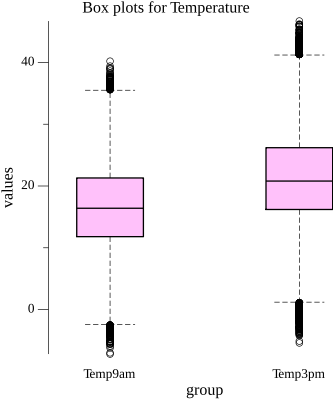

In [18]:
%%

Show2ColsBoxPlot (data.Col("Temp9am"), data.Col("Temp3pm"), "Temp9am", "Temp3pm", "Temperature")

In [85]:
func isColumnEmpty(dataset [][]float64, col int) bool {
	for _, row := range dataset {
		if !math.IsNaN(row[col]) {
			return false
		}
	}
	return true
}  

type plottable struct {
	grid [][]float64
	N int
	M int
	resolution float64
	minX float64
	minY float64
  }

func (p plottable) Dims() (c, r int) {
	return p.N, p.M
}
func (p plottable) X(c int) float64 {
	return p.minX + float64(c)*p.resolution
}
func (p plottable) Y(r int) float64 {
	return p.minY + float64(r)*p.resolution
}
func (p plottable) Z(c, r int) float64 {
	return p.grid[c][r]
}

func ShowHeatMap (df dataframe.DataFrame, col1, col2, col3 string) {

    axisY := df.Col(col1)
    axisX := df.Col(col2)
    values := df.Col(col3)
    
    resultMap := make(map[int]map[int]float64)
    for i := 0; i < values.Len(); i++ {
        keyY, _ := axisY.Elem(i).Int()
        keyX, _ := axisX.Elem(i).Int()
        if _, ok := resultMap[keyY]; !ok {
            resultMap[keyY] = make(map[int]float64)
        }
       resultMap[keyY][keyX] = values.Elem(i).Float()
      }
    lenghtX := len(GetUniqueValues(axisX))
    lenghtY := len(GetUniqueValues(axisY))

    dataset := make([][]float64, lenghtX)
    for i := range dataset {
    	dataset[i] = make([]float64, lenghtY) 
    	for j := range dataset[i] {
    		dataset[i][j] = math.NaN()
    	}
    }

    for aY, data := range resultMap {
        j := aY - int(axisY.Min())
    	for aX, value := range data {
    		dataset[aX-1][j] = value 
    	}
    }
    nonEmptyColumns := make([]int, 0)
    for j := 0; j < lenghtY; j++ {
    	if !isColumnEmpty(dataset, j) {
    		nonEmptyColumns = append(nonEmptyColumns, j)
    	}
    }
    newDataset := make([][]float64, len(dataset))
    for i := range newDataset {
    	newDataset[i] = make([]float64, len(nonEmptyColumns))
    	for j, col := range nonEmptyColumns {
    		newDataset[i][j] = dataset[i][col]
    	}
    }
    dataset = newDataset

    plotData := plottable{
    	grid: dataset,
    	N: len(dataset),
    	M: len(dataset[0]),
    	minX: 0,
    	minY: axisY.Min()-0.5,
    	resolution: 1,
    	}
    pal := moreland.SmoothBlueRed().Palette(255)
    hm := plotter.NewHeatMap(plotData, pal)

    p := plot.New()
    nameTitle := fmt.Sprintf("Heatmap of the indicator %s by %s and %s", col3, col1, col2)
    nameX := fmt.Sprintf("Values %s", col2)
    nameY := fmt.Sprintf("Values %s", col1)
    p.Title.Text = nameTitle
    p.X.Label.Text = nameX
    p.Y.Label.Text = nameY
    //p.NominalY(labels...)

    p.Add(hm)

    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Length(800), vg.Length(600), "png")
    if err != nil {
    	panic(err)
    }
    writerTo.WriteTo(buf)
    gonbui.DisplayPNG(buf.Bytes())
}

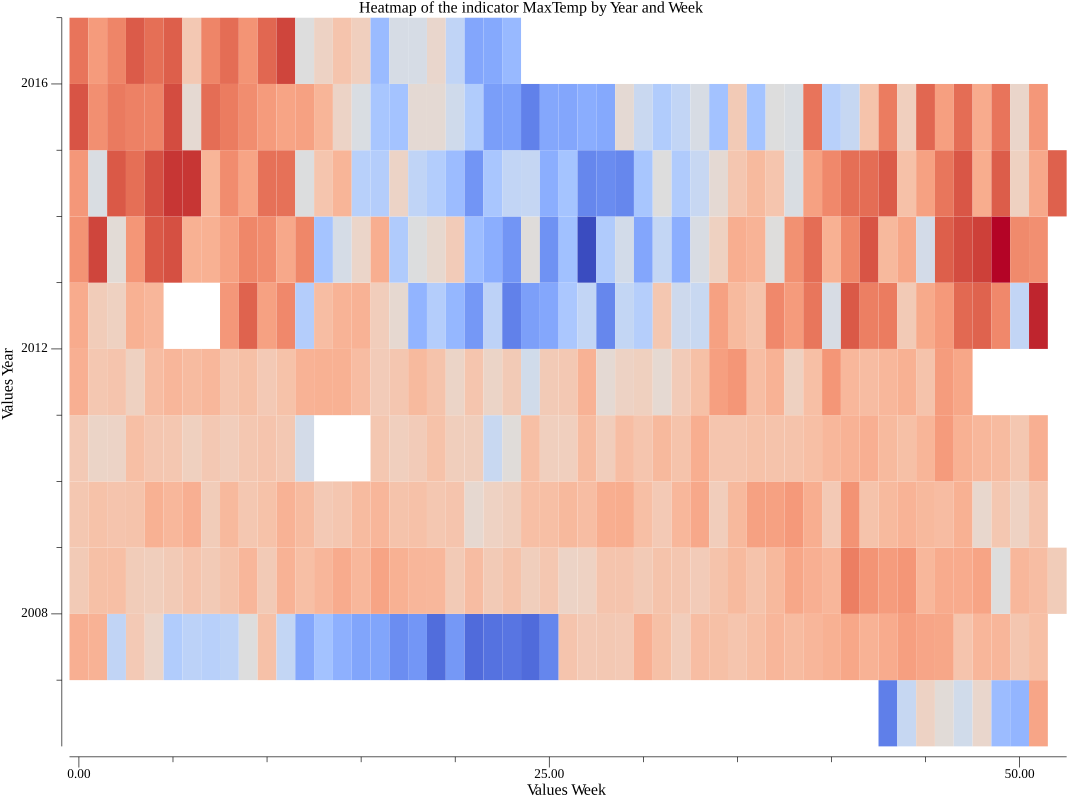

In [86]:
%%

ShowHeatMap(data, "Year", "Week", "MaxTemp")